In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import time

import warnings
warnings.filterwarnings('ignore')

original_corpus = pd.read_csv('data/mental_health.csv')
cleaned_corpus = pd.read_csv('data/cleaned_mhc.csv')

print("Shape of Original Corpus", original_corpus.shape)
print("Shape of Cleaned Corpus", cleaned_corpus.shape)

Shape of Original Corpus (27977, 2)
Shape of Cleaned Corpus (23240, 2)


In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

# Function to preprocess and evaluate models
def evaluate_logistic_regression(corpus):
    # Vectorization
    X = corpus['text']  # Assuming the text column is named 'text'
    y = corpus['label']  # Assuming the label column is named 'label'

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the TF-IDF Vectorizer
    tfidf = TfidfVectorizer(max_features=3500)
    
    # Fit the vectorizer on the training data and transform both training and testing data
    X_train_tfidf = tfidf.fit_transform(X_train).toarray()
    X_test_tfidf = tfidf.transform(X_test).toarray()

    # Define the model and parameters for Grid Search
    model = LogisticRegression(max_iter=1000)
    param_grid = {
        'C': [0.1, 1, 10],
        'solver': ['liblinear', 'saga', 'lbfgs']
    }

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', verbose=1)
    
    # Fit the model
    start_time = time.time()
    grid_search.fit(X_train_tfidf, y_train)
    fitting_time = time.time() - start_time

    # Best model
    best_model = grid_search.best_estimator_

    # Predict on the test set
    start_time = time.time()
    y_pred = best_model.predict(X_test_tfidf)
    test_time = time.time() - start_time

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    results = {
        'model': best_model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'fitting_time': fitting_time,
        'test_time': test_time,
        'confusion_matrix': conf_matrix
    }

    return results

# Evaluate on original corpus
results_original = evaluate_logistic_regression(original_corpus)
print("\nResults for Original Corpus:")
print(f"Test Accuracy: {results_original['accuracy']:.4f}")
print(f"Precision: {results_original['precision']:.4f}")
print(f"Recall: {results_original['recall']:.4f}")
print(f"F1 Score: {results_original['f1']:.4f}")
print(f"Training Time: {results_original['fitting_time']:.4f} seconds")
print(f"Test Time: {results_original['test_time']:.4f} seconds")
print("Confusion Matrix:\n", results_original['confusion_matrix'])

# Evaluate on cleaned corpus
results_cleaned = evaluate_logistic_regression(cleaned_corpus)
print("\nResults for Cleaned Corpus:")
print(f"Test Accuracy: {results_cleaned['accuracy']:.4f}")
print(f"Precision: {results_cleaned['precision']:.4f}")
print(f"Recall: {results_cleaned['recall']:.4f}")
print(f"F1 Score: {results_cleaned['f1']:.4f}")
print(f"Training Time: {results_cleaned['fitting_time']:.4f} seconds")
print(f"Test Time: {results_cleaned['test_time']:.4f} seconds")
print("Confusion Matrix:\n", results_cleaned['confusion_matrix'])

# The models are stored in results_original['model'] and results_cleaned['model'] for further analysis

Fitting 5 folds for each of 9 candidates, totalling 45 fits

Results for Original Corpus:
Test Accuracy: 0.9219
Precision: 0.9278
Recall: 0.9148
F1 Score: 0.9212
Training Time: 159.2078 seconds
Test Time: 0.0312 seconds
Confusion Matrix:
 [[2603  199]
 [ 238 2556]]
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Results for Cleaned Corpus:
Test Accuracy: 0.9228
Precision: 0.9301
Recall: 0.9290
F1 Score: 0.9295
Training Time: 127.8067 seconds
Test Time: 0.0071 seconds
Confusion Matrix:
 [[1921  178]
 [ 181 2368]]


Plotting heatmap for Original Corpus model...


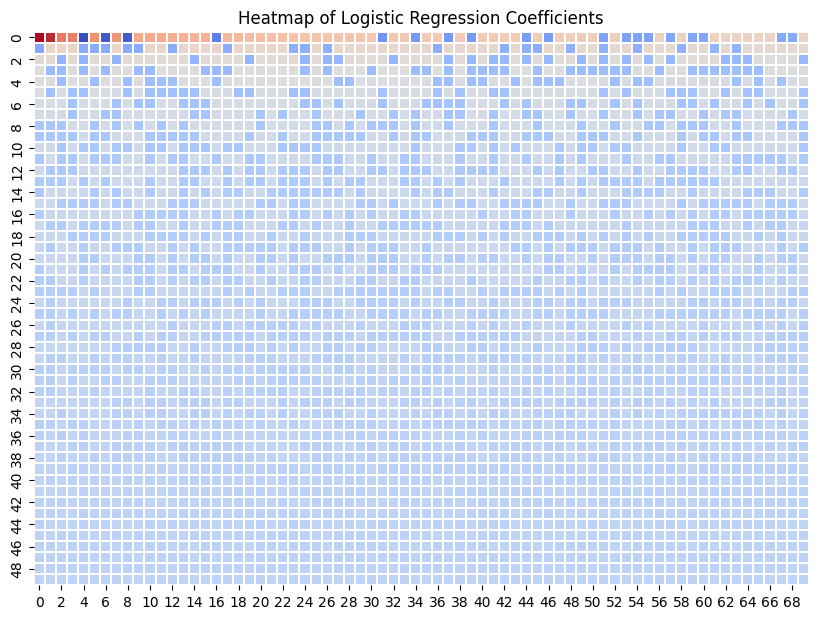

Plotting heatmap for Cleaned Corpus model...


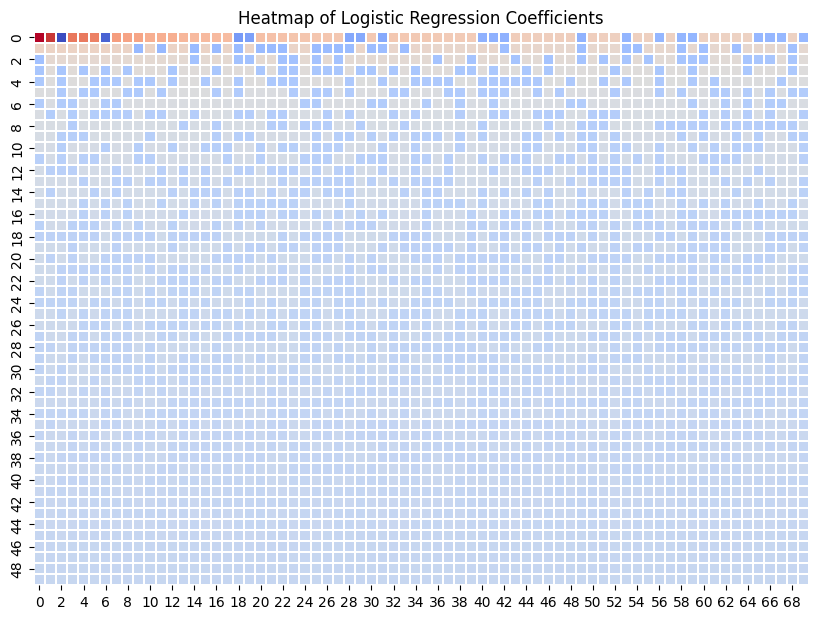

In [3]:
# Function to extract and visualize coefficients
def plot_coefficients_heatmap(corpus, model, rows=50, cols=70):
    # Vectorization
    X = corpus['text']  # Assuming the text column is named 'text'
    y = corpus['label']  # Assuming the label column is named 'label'

    # Initialize the TF-IDF Vectorizer
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    tfidf = TfidfVectorizer(max_features=3500)
    
    X_tfidf = tfidf.fit_transform(X_train).toarray()

    # Get coefficients
    coefficients = model.coef_[0]  # Assuming binary classification

    # Create a DataFrame with feature names and their corresponding coefficients
    feature_names = tfidf.get_feature_names_out()
    coeff_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})

    # Sort the DataFrame by absolute coefficient value
    coeff_df['abs_coefficient'] = coeff_df['coefficient'].abs()
    coeff_df = coeff_df.sort_values(by='abs_coefficient', ascending=False)

    # Ensure we have enough coefficients to reshape
    if len(coeff_df) < rows * cols:
        print(f"Warning: Not enough features to fill a {rows}x{cols} heatmap. Adjusting size.")
        rows = len(coeff_df) // cols + 1  # Adjust rows based on available features

    # Create a heatmap with specified dimensions
    coeff_matrix = coeff_df['coefficient'].values[:rows * cols].reshape(rows, cols)

    # Set up the figure and axis for the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(coeff_matrix, cmap='coolwarm', cbar=False, square=True, linewidths=0.1)
    plt.title('Heatmap of Logistic Regression Coefficients')
    plt.show()

# Plot heatmap for original corpus model
print("Plotting heatmap for Original Corpus model...")
plot_coefficients_heatmap(original_corpus, results_original['model'])

# Plot heatmap for cleaned corpus model
print("Plotting heatmap for Cleaned Corpus model...")
plot_coefficients_heatmap(cleaned_corpus, results_cleaned['model'])

In [6]:
# Function to print top and bottom coefficients based on absolute values
def print_top_bottom_coefficients(corpus, model):
    # Vectorization
    X = corpus['text']  # Assuming the text column is named 'text'
    y = corpus['label']  # Assuming the label column is named 'label'
    
    # Initialize the TF-IDF Vectorizer
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    tfidf = TfidfVectorizer(max_features=3500)
    
    X_tfidf = tfidf.fit_transform(X_train).toarray()

    # Get coefficients
    coefficients = model.coef_[0]  # Assuming binary classification
    feature_names = tfidf.get_feature_names_out()

    # Create a DataFrame with feature names and their corresponding coefficients
    coeff_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})

    # Sort the DataFrame by absolute coefficient value
    coeff_df_sorted = coeff_df.sort_values(by='coefficient', ascending=False)

    # Top 25 largest coefficients by absolute value
    top_25 = coeff_df_sorted.head(25)
    print("Top 25 Largest Coefficients:")
    print(top_25[['feature', 'coefficient']])

    # Bottom 25 smallest coefficients by absolute value (which are the least impactful)
    bottom_25 = coeff_df_sorted.tail(25)
    print("\nBottom 25 Smallest Coefficients:")
    print(bottom_25[['feature', 'coefficient']])

# Print top and bottom coefficients for original corpus model
print("Top and Bottom Coefficients for Original Corpus model:")
print_top_bottom_coefficients(original_corpus, results_original['model'])

# Print top and bottom coefficients for cleaned corpus model
print("\nTop and Bottom Coefficients for Cleaned Corpus model:")
print_top_bottom_coefficients(cleaned_corpus, results_cleaned['model'])


Top and Bottom Coefficients for Original Corpus model:
Top 25 Largest Coefficients:
         feature  coefficient
2475     redflag     7.969420
1689        kill     7.536137
809          die     5.588684
2968    suicidal     5.469427
1777        life     4.948059
454       cannot     4.787238
774   depression     4.204497
1692     killing     4.186983
2024      myself     4.076472
973          end     3.991266
142      anymore     3.885090
91         alive     3.827340
2256       pills     3.808736
1806      living     3.589986
1125        feel     3.516295
3339        want     3.356544
748        death     3.251435
3198       tried     3.190152
2969     suicide     3.129144
3450       worse     3.079689
2287       point     3.049736
3107    thoughts     3.047477
2171        pain     3.030478
1900          me     3.011963
97         alone     2.994993

Bottom 25 Smallest Coefficients:
        feature  coefficient
1342      great    -2.070407
714        cute    -2.079346
3027    teacher

In [4]:
# Function to print top and bottom coefficients based on absolute values
def print_top_bottom_coefficients(corpus, model):
    # Vectorization
    X = corpus['text']  # Assuming the text column is named 'text'
    y = corpus['label']  # Assuming the label column is named 'label'
    
    # Initialize the TF-IDF Vectorizer
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    tfidf = TfidfVectorizer(max_features=3500)
    
    X_tfidf = tfidf.fit_transform(X_train).toarray()

    # Get coefficients
    coefficients = model.coef_[0]  # Assuming binary classification
    feature_names = tfidf.get_feature_names_out()

    # Create a DataFrame with feature names and their corresponding coefficients
    coeff_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})

    # Sort the DataFrame by absolute coefficient value
    coeff_df['abs_coefficient'] = coeff_df['coefficient'].abs()
    coeff_df_sorted = coeff_df.sort_values(by='abs_coefficient', ascending=False)

    # Top 25 largest coefficients by absolute value
    top_25 = coeff_df_sorted.head(25)
    print("Top 25 Largest Coefficients (by absolute value):")
    print(top_25[['feature', 'coefficient']])

    # Bottom 25 smallest coefficients by absolute value (which are the least impactful)
    bottom_25 = coeff_df_sorted.tail(25)
    print("\nBottom 25 Smallest Coefficients (by absolute value):")
    print(bottom_25[['feature', 'coefficient']])

# Print top and bottom coefficients for original corpus model
print("Top and Bottom Coefficients for Original Corpus model:")
print_top_bottom_coefficients(original_corpus, results_original['model'])

# Print top and bottom coefficients for cleaned corpus model
print("\nTop and Bottom Coefficients for Cleaned Corpus model:")
print_top_bottom_coefficients(cleaned_corpus, results_cleaned['model'])


Top and Bottom Coefficients for Original Corpus model:
Top 25 Largest Coefficients (by absolute value):
         feature  coefficient
2475     redflag     7.969420
1689        kill     7.536137
809          die     5.588684
2968    suicidal     5.469427
383           br    -5.220313
1777        life     4.948059
1148        film    -4.854881
454       cannot     4.787238
2009       movie    -4.740891
774   depression     4.204497
1692     killing     4.186983
2024      myself     4.076472
973          end     3.991266
142      anymore     3.885090
91         alive     3.827340
2256       pills     3.808736
699        crush    -3.698827
1806      living     3.589986
1125        feel     3.516295
3339        want     3.356544
748        death     3.251435
3198       tried     3.190152
2969     suicide     3.129144
3450       worse     3.079689
2287       point     3.049736

Bottom 25 Smallest Coefficients (by absolute value):
          feature  coefficient
1828        loose    -0.005647


In [5]:
# Function to print the hyperparameters of the models
def print_model_hyperparameters(grid_search_result):
    # Extract the best model from grid search
    best_model = grid_search_result['model']
    
    # Print the hyperparameters
    print("Model Hyperparameters:")
    for param, value in best_model.get_params().items():
        print(f"{param}: {value}")

# Print hyperparameters for the original corpus model
print("Hyperparameters for Original Corpus model:")
print_model_hyperparameters(results_original)

# Print hyperparameters for the cleaned corpus model
print("\nHyperparameters for Cleaned Corpus model:")
print_model_hyperparameters(results_cleaned)

Hyperparameters for Original Corpus model:
Model Hyperparameters:
C: 1
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 1000
multi_class: deprecated
n_jobs: None
penalty: l2
random_state: None
solver: saga
tol: 0.0001
verbose: 0
warm_start: False

Hyperparameters for Cleaned Corpus model:
Model Hyperparameters:
C: 1
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 1000
multi_class: deprecated
n_jobs: None
penalty: l2
random_state: None
solver: lbfgs
tol: 0.0001
verbose: 0
warm_start: False


In [16]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD

# Function to preprocess and evaluate models
def evaluate_logistic_regression(corpus):
    # Vectorization
    X = corpus['text']  # Assuming the text column is named 'text'
    y = corpus['label']  # Assuming the label column is named 'label'

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the TF-IDF Vectorizer
    tfidf = TfidfVectorizer(max_features=3500)
    
    # Fit the vectorizer on the training data and transform both training and testing data
    n_components = 100
    lsa = TruncatedSVD(n_components=n_components, random_state=42)
        
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_train_tfidf = lsa.fit_transform(X_train_tfidf)    
    X_test_tfidf = tfidf.transform(X_test)
    X_test_tfidf = lsa.transform(X_test_tfidf)

    # Define the model and parameters for Grid Search
    model = LogisticRegression(max_iter=1000)
    param_grid = {
        'C': [0.1, 1, 10],
        'solver': ['liblinear', 'saga', 'lbfgs']
    }

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', verbose=1)
    
    # Fit the model
    start_time = time.time()
    grid_search.fit(X_train_tfidf, y_train)
    fitting_time = time.time() - start_time

    # Best model
    best_model = grid_search.best_estimator_

    # Predict on the test set
    start_time = time.time()
    y_pred = best_model.predict(X_test_tfidf)
    test_time = time.time() - start_time

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    results = {
        'model': best_model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'fitting_time': fitting_time,
        'test_time': test_time,
        'confusion_matrix': conf_matrix
    }

    return results

# Evaluate on original corpus
results_original = evaluate_logistic_regression(original_corpus)
print("\nResults for Original Corpus:")
print(f"Test Accuracy: {results_original['accuracy']:.4f}")
print(f"Precision: {results_original['precision']:.4f}")
print(f"Recall: {results_original['recall']:.4f}")
print(f"F1 Score: {results_original['f1']:.4f}")
print(f"Training Time: {results_original['fitting_time']:.4f} seconds")
print(f"Test Time: {results_original['test_time']:.4f} seconds")
print("Confusion Matrix:\n", results_original['confusion_matrix'])

# Evaluate on cleaned corpus
results_cleaned = evaluate_logistic_regression(cleaned_corpus)
print("\nResults for Cleaned Corpus:")
print(f"Test Accuracy: {results_cleaned['accuracy']:.4f}")
print(f"Precision: {results_cleaned['precision']:.4f}")
print(f"Recall: {results_cleaned['recall']:.4f}")
print(f"F1 Score: {results_cleaned['f1']:.4f}")
print(f"Training Time: {results_cleaned['fitting_time']:.4f} seconds")
print(f"Test Time: {results_cleaned['test_time']:.4f} seconds")
print("Confusion Matrix:\n", results_cleaned['confusion_matrix'])

# The models are stored in results_original['model'] and results_cleaned['model'] for further analysis

Fitting 5 folds for each of 9 candidates, totalling 45 fits

Results for Original Corpus:
Test Accuracy: 0.9076
Precision: 0.9126
Recall: 0.9012
F1 Score: 0.9069
Training Time: 5.1602 seconds
Test Time: 0.0000 seconds
Confusion Matrix:
 [[2561  241]
 [ 276 2518]]
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Results for Cleaned Corpus:
Test Accuracy: 0.9099
Precision: 0.9206
Recall: 0.9145
F1 Score: 0.9175
Training Time: 3.9624 seconds
Test Time: 0.0012 seconds
Confusion Matrix:
 [[1898  201]
 [ 218 2331]]


In [12]:
# Function to print the hyperparameters of the models
def print_model_hyperparameters(grid_search_result):
    # Extract the best model from grid search
    best_model = grid_search_result['model']
    
    # Print the hyperparameters
    print("Model Hyperparameters:")
    for param, value in best_model.get_params().items():
        print(f"{param}: {value}")

# Print hyperparameters for the original corpus model
print("Hyperparameters for Original Corpus model:")
print_model_hyperparameters(results_original)

# Print hyperparameters for the cleaned corpus model
print("\nHyperparameters for Cleaned Corpus model:")
print_model_hyperparameters(results_cleaned)

Hyperparameters for Original Corpus model:
Model Hyperparameters:
C: 10
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 1000
multi_class: deprecated
n_jobs: None
penalty: l2
random_state: None
solver: lbfgs
tol: 0.0001
verbose: 0
warm_start: False

Hyperparameters for Cleaned Corpus model:
Model Hyperparameters:
C: 10
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 1000
multi_class: deprecated
n_jobs: None
penalty: l2
random_state: None
solver: lbfgs
tol: 0.0001
verbose: 0
warm_start: False
